In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, classification_report
import time

In [ ]:
image_dir = Path(r'/content/drive/MyDrive/HUMZA_FYP/Classification_dataset')

In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

batch_size = 16
img_height = 228
img_width = 228
channels = 3
img_shape = (img_height, img_width, channels)

# pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')
pre_trained = VGG16(input_shape = img_shape,include_top = False, weights = 'imagenet')


for layer in pre_trained.layers:
    layer.trainable = False
    
num_c = 8


# x = pre_trained.output
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = Dropout(0.2)(x)
# x = Dense(1024, activation='LeakyReLU')(x)
# x = Dropout(0.2)(x)
# predictions = Dense(num_c, activation='softmax')(x)

# model1 = Model(inputs = pre_trained.input, outputs = predictions)
# model1.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


x = layers.Flatten()(pre_trained.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(8, activation='softmax')(x)
model1 = tf.keras.models.Model(pre_trained.input, x)

model1.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])


STEP_SIZE_TRAIN = train_images.n // train_images.batch_size
STEP_SIZE_VALID = val_images.n // val_images.batch_size

history = model1.fit_generator(train_images,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_images,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 15,
                    verbose = 1)

results = model1.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Found 448 validated image filenames belonging to 8 classes.
Found 112 validated image filenames belonging to 8 classes.
Found 240 validated image filenames belonging to 8 classes.
58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-5-e3d2a5041c1f>:88: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_images,


Epoch 1/15
14/14 [==============================] - 117s 7s/step - loss: 5.6502 - acc: 0.2768 - val_loss: 1.3607 - val_acc: 0.5938
Epoch 2/15
14/14 [==============================] - 6s 460ms/step - loss: 1.3310 - acc: 0.6116 - val_loss: 0.7400 - val_acc: 0.8021
Epoch 3/15
14/14 [==============================] - 6s 396ms/step - loss: 0.6062 - acc: 0.7946 - val_loss: 0.3997 - val_acc: 0.9062
Epoch 4/15
14/14 [==============================] - 6s 429ms/step - loss: 0.3779 - acc: 0.8929 - val_loss: 0.3654 - val_acc: 0.8958
Epoch 5/15
14/14 [==============================] - 6s 394ms/step - loss: 0.2792 - acc: 0.9174 - val_loss: 0.3687 - val_acc: 0.8542
Epoch 6/15
14/14 [==============================] - 5s 384ms/step - loss: 0.2580 - acc: 0.9330 - val_loss: 0.3036 - val_acc: 0.9062
Epoch 7/15
14/14 [==============================] - 8s 571ms/step - loss: 0.1637 - acc: 0.9688 - val_loss: 0.3095 - val_acc: 0.8958
Epoch 8/15
14/14 [==============================] - 5s 380ms/step - loss: 0.1

In [ ]:
from keras.models import load_model

model1.save('model_1_v2.h5')

In [ ]:
image_dir = Path(r'/content/drive/MyDrive/HUMZA_FYP/Grading Dataset/Grading_dataset')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(200, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_df

,Filepath,Label
241,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
400,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
286,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
379,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade C
314,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
...,...,...
129,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade C
144,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
72,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A
235,/content/drive/MyDrive/HUMZA_FYP/Grading Datas...,Grade A


In [ ]:
strr = str(train_df['Filepath'].iloc[54])

In [ ]:
strr

'/content/drive/MyDrive/HUMZA_FYP/Grading Dataset/Grading_dataset/Grade B/IMG_20210703_151819.jpg'

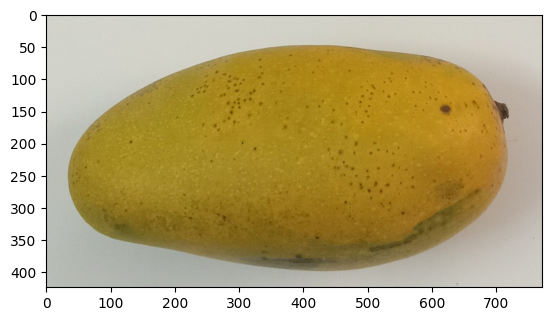

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(strr)
imgplot = plt.imshow(img)
plt.show()

In [ ]:


train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)


train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

batch_size = 16
img_height = 228
img_width = 228
channels = 3
img_shape = (img_height, img_width, channels)


# pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='avg')
pre_trained = VGG16(input_shape = img_shape,include_top = False, weights = 'imagenet')


for layer in pre_trained.layers:
    layer.trainable = False
    
num_c = 3

# x = pre_trained.output
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
# x = Dropout(0.2)(x)
# x = Dense(1024, activation='LeakyReLU')(x)
# x = Dropout(0.2)(x)
# predictions = Dense(num_c, activation='softmax')(x)

# model2 = Model(inputs = pre_trained.input, outputs = predictions)
# model2.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

x = layers.Flatten()(pre_trained.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)
model2 = tf.keras.models.Model(pre_trained.input, x)

model2.compile(optimizer = Adam(lr=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])


STEP_SIZE_TRAIN = train_images.n // train_images.batch_size
STEP_SIZE_VALID = val_images.n // val_images.batch_size

history = model2.fit_generator(train_images,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_images,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 10,
                    verbose = 1)

results = model2.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Found 336 validated image filenames belonging to 3 classes.
Found 84 validated image filenames belonging to 3 classes.
Found 180 validated image filenames belonging to 3 classes.
58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-35-457aeb490b8a>:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_images,


Epoch 1/10
10/10 [==============================] - 90s 7s/step - loss: 6.7346 - acc: 0.3783 - val_loss: 1.6041 - val_acc: 0.6250
Epoch 2/10
10/10 [==============================] - 5s 526ms/step - loss: 1.7164 - acc: 0.5493 - val_loss: 0.6394 - val_acc: 0.6719
Epoch 3/10
10/10 [==============================] - 3s 344ms/step - loss: 0.8462 - acc: 0.7204 - val_loss: 0.3979 - val_acc: 0.7656
Epoch 4/10
10/10 [==============================] - 4s 404ms/step - loss: 0.5613 - acc: 0.7937 - val_loss: 0.5780 - val_acc: 0.6875
Epoch 5/10
10/10 [==============================] - 4s 373ms/step - loss: 0.3992 - acc: 0.8487 - val_loss: 0.4576 - val_acc: 0.8125
Epoch 6/10
10/10 [==============================] - 3s 309ms/step - loss: 0.3297 - acc: 0.8914 - val_loss: 0.2696 - val_acc: 0.9219
Epoch 7/10
10/10 [==============================] - 5s 458ms/step - loss: 0.2865 - acc: 0.8816 - val_loss: 0.3004 - val_acc: 0.9062
Epoch 8/10
10/10 [==============================] - 3s 328ms/step - loss: 0.23

In [ ]:
from keras.models import load_model

model2.save('model_2_v3.h5')